# Naive Bayes (NB) Classifier

In this notebook we will implement NB Classifier from scratch.

NB Classifer is used in applications like **document classification** and **spam filtering**.

In [1]:
#@title [Import Libraries]
# Imported for proper rendering of Latex in notebook
from IPython.display import display, Math, Latex

import numpy as np

# Import for generating plots
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We also set a random seed in order to reproduce the same results across diferrent runs in this notebook.

In [2]:
np.random.seed(69)

**NOTES:**
For complete derivation of the mathematical model, check my handwritten scratch at [notes](https://github.com/sampadk04/Naive_Bayes_Classifier_from_scratch/blob/main/Naive_Bayes_Classifier_Notes.pdf).

# Model

- Naive Bayes classifer is a **generative classifer**.
- It **estimates** probability of a sample belonging to a class using **Bayes Theorem**:
$$\text{posterior} = \frac{\text{prior} \times \text{likelihood}}{\text{evidence}}$$
$$p(y|\vec{x}) = \frac{p(y) \times p(\vec{x}|y)}{p(\vec{x})}$$
- It simplifies the calculation of **likelihood** with **conditional independence assumption**: NB assumes that the *features are conditionally independent given labels*.
    - The **likelihood** can be expressed as:
    $$p(\vec{x}|y) = p(x_1, x_2, \dots, x_m| y) = p(x_1|y) p(x_2|y) \dots p(x_m|y) = \prod^{m}_{j = 1} p(x_j|y)$$

- Substituting likelihood in Bayes Theorem gives us the following formula:
$$p(y = y_c | \vec{x}) = \frac{p(y_c) \prod^{m}_{j = 1} p(x_j|y_c)}{\sum^{k}_{r=1} \prod^{m}_{j = 1} p(x_j|y_r)}$$

# Inference

- We perform this calculation in the **log-space** to avoid issues with underflow die to multiplication of small numbers:
    - The label that results in the **highest value of the numerator** i.e. $\text{prior} \times \text{likelihood}$ is assigned to the given example. *Note that the evidence is fixed for all labels and acts as a normalizing constant*.
    $$y = \argmax_{y_c} \log p(y_c) + \sum^{m}_{j = 1} \log p(x_j | y_c) $$

# Learning Problem
- $k$ prior probabilities to be estimated: $\{ p(y_1), p(y_2), \dots, p(y_k) \}$
- $k \times m$ class conditional probabilities ($m$ each for each class label $y_c$): $ \{ p(x_1|y_c), p(x_2|y_c), \dots, p(x_m|y_c) \} $.

The class conditional denstities depend on the nature of features.

The following are some popular class conditional densities used in NB classifier:
- **Bernoulli distribution:** When $x_j$ is a **binary feature**, we use Bernoulli Distribution to model the class conditional density: $p(x_j|y_c)$.
- **Categorical distribution:** When $x_j$ is a **categorical feature** i.e. it takes one of the $e>2$ discrete values [e.g. colours from the set {red, green, blue} or roll of a dice], we use categorical distribution to model the class conditional density $p(x_j | y_c)$.
- **Multinomial distribution:** When $\vec{x}$ is a count vector i.e. each component $x_j$ is a count of appearance of the object it represents and $\sum^{m}_{j = 1} x_j = l$, where $l$ is the total no. of objects (which is fixed), we use multinomial distribution to model $p(\vec{x}|y_c)$.
- **Gaussian distribution:** When $x_j$ is a continuous feature i.e. it takes a real value, we use gaussian (or normal) distribution to model class conditional density $p(x_j|y_c)$.

In this notebook, we will implement these different types of class conditional densities in different NB implementations. We will discuss the parameter estimation in the respective sections.

# Bernoulli NB: Implementation

## Parameter Estimation: Class Conditional Density and Prior

- Class conditional density for Bernoulli NB is calculated as follows:
$$w_{j y_c} = \frac{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_c)} x^{(i)}_j}{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_c)}} $$

- This is basically the average of feature values $x_j$ in examples labelled $y_c$.
    - $\mathbb{1}_{(y^{(i)} = y_c)}$ get us the examples with label $y_c$ (Indicator Function).
    - Numerator sums up $x_j$ across all examples with label $y_c$.
    - And this is divided by the total no. of examples with label $y_c$.

- The class prior is obtained as follows:
$$w_{y_c} = \frac{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_c)}}{n} $$

- Here, the numerator gives the total no. of examples with label $y_c$ and is divided by the total no. of examples in the training set (This gives the class prior an empirical distribution).

- While estimating parameters of the model, we process examples from each label separately and estimate the parameters.

Detailed derivations of these can be found in my handwritten notes at this [link](https://github.com/sampadk04/Naive_Bayes_Classifier_from_scratch/blob/main/Naive_Bayes_Classifier_Notes.pdf).

In [3]:
def fit(X,y):
    n_samples, n_features = X.shape
    class_count = np.unique(y)
    n_classes = len(class_count)

    # initialize the weight vectors.
    w_ccd = np.zeros((n_classes, n_features), dtype=np.float64)
    w_prior = np.zeros(n_classes, dtype=np.float64)

    for c in range(n_classes): # processing examples from each class separately
        # extract examples with labels c
        X_c = X[y==c]

        # estimation of w_ccd[c,j]: The parameter of Bernoulli distribution
        # p(x_j | y_c) ~ Bernoulli(w_ccd[c,j])
        # we have vectorized this operation and we obtain the vector w_ccd[c,:] that contains w_ccd[c,j] for each j \in [m]
        w_ccd[c, :] = np.sum(X_c, axis=0)/X_c.shape[0]

        # estimation of prior probability: w_prior[c]
        w_prior[c] = X_c.shape[0]/float(n_samples)

    print("Weights:\n", w_ccd)
    print("Priors:\n", w_prior)
    return w_ccd, w_prior

Let's look at the parameter estimation in a step by step manner:

In [4]:
# feature matrix with shape (4,2). x_1 ~ Bernoulli(w[1,0]) [x1 = 1] and x_2 ~ Bernoulli(w[1,1]) [x2 = 1]
X = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
])

# label vector with shape (4,)
y = np.array([1, 0, 0, 1])

# call fit with feature matric and label vector as arguments
_,_ = fit(X,y)

# returns parameters of class conditional bernoulli distribution and priors

Weights:
 [[0. 1.]
 [1. 0.]]
Priors:
 [0.5 0.5]


A few observations:
- Since there are $50 \%$ examples of each class $0$ and $1$, the prior probability vector has $0.5$ for each class.
- Note that:
    - For class $0$: $w[0,0] = 0$ and $w[0,1] = 1$, hence the parameters of bernoulli distributions are $0$ and $1$ respectively.
    - For class $1$: $w[1,0] = 1$ and $w[1,1] = 0$, hence the parameters of bernoulli distributions are $1$ and $0$ respectively.

## Incorporating Laplace Correction

The $0$ value for parameter is a problem as it leads to $0$ posterior probability. We can fix this problem with **Laplace Correction** or by adding small dummy counts in each class for each feature.
    - The **class priors** with laplace correction can be calculates as follows:
    $$p(y = y_c) = w_{y_c} = \frac{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_c)} + \alpha}{n + k \alpha} $$
    - The **class conditional density** with laplace correction is computed as follows:
    $$w_{j y_c} = \frac{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_c)} x^{(i)}_j + \alpha}{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_c)} + 2 \alpha} $$

## Inference

### Determine Class Label

We assign class label $y^*$ that results in the largest product of likelihood and prior.
$$y^* = \argmax_{y_c} (\sum^{m}_{j=1} \log p(x_j|y_c; \vec{w})) + \log p(y_c;\vec{w}) $$
$$\implies y^* = \argmax_{y_c} (\sum^{m}_{j=1} \log w^{x_j}_{j y_c}(1 - w_{j y_c})^{1 - x_j}) + \log p(y_c;\vec{w})$$
$$\implies y^* =  \argmax_{y_c} (\sum^{m}_{j=1} x_j \log w_{j y_c} + (1-x_j) \log (1 - w_{j y_c}) )  + \log p(y_c;\vec{w})$$

Note that we perform these computations in log space to avoid the problem with underflow.

Further with vectorization, this is implemented as follows:
$$ y^* = \argmax_{y} X \log w^T + (1 - X) \log (1 - w)^T + \log w_{\text{prior}} $$

## Implementation of Bernoulli NB Class

In [5]:
class BernoulliNB(object):
    '''
    Class Conditional Density following Bernoulli Distribution
    '''

    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, y):
        '''
        Parameter estimation for Bernoulli distribution
        '''
        n_samples, n_features = X.shape
        class_count = np.unique(y)
        n_classes = len(class_count)

        # initialize the weight vectors.
        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_prior = np.zeros(n_classes, dtype=np.float64)

        for c in range(n_classes): # processing examples from each class separately
            # extract examples with labels c
            X_c = X[y==c]

            # estimation of w[c,j]: The parameter of Bernoulli distribution
            # p(x_j | y_c) ~ Bernoulli(w[c,j])
            # we have vectorized this operation and we obtain the vector w[c,:] that contains w[c,j] for each j \in [m]
            self.w[c, :] = (np.sum(X_c, axis=0) + self.alpha)/(X_c.shape[0] + 2*self.alpha)

            # estimation of prior probability: w_prior[c]
            self.w_prior[c] = (X_c.shape[0] + self.alpha)/(float(n_samples) + n_classes*self.alpha)

        print("CCD Weights:\n", self.w)
        print("Priors:\n", self.w_prior)
    
    def log_likelihood_prior_prod(self, X):
        '''
        Calculates the product of likelihood and prior in the log space
        '''
        return X @ (np.log(self.w).T) + (1 - X) @ np.log(1 - self.w).T + np.log(self.w_prior)
    
    def predict_prob(self, X):
        '''
        Calculates probabilities of each example belonging to different classes.
        '''
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q)/(np.expand_dims(np.sum(np.exp(q), axis=1), axis=1))
    
    def predict(self,X):
        '''
        Predicts class label for each example.
        '''
        return np.argmax(self.log_likelihood_prior_prod(X), axis=1)

## Demo

### Binary Classification

In [6]:
# feature matrix with shape (4,2). x_1 ~ Bernoulli(w[1,0]) [x1 = 1] and x_2 ~ Bernoulli(w[1,1]) [x2 = 1]
X = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
])

# label vector with shape (4,)
y = np.array([1, 0, 0, 1])

In [7]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X,y)

CCD Weights:
 [[0.25 0.75]
 [0.75 0.25]]
Priors:
 [0.5 0.5]


In [8]:
# Let's predict classes for input example
bernoulli_nb.predict(X)

array([1, 0, 0, 1])

In [9]:
# The class labels are inferred by selecting the label that results into
# the highest value of product of likelihood and priors:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

Observe that based on this calculation, the first example gets class $1$, the second gets class $0$, the third gets class $0$ and the fourth class $1$, based on the argmax strategy.

In [10]:
# Let's predict probabilities of each example.
bernoulli_nb.predict_prob(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

Based on the probabilities also, the output makes sense.

### Multiclass Classification

The NB implementation also works in the multiclass setting. Here is an example with $3$ classes.

In [11]:
X = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
    [1, 1],
    [1, 1],
])

y = np.array([1, 0, 0, 1, 2, 2])

Estimation of parameters of Bernoulli distributions and class priors.

In [12]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

CCD Weights:
 [[0.25 0.75]
 [0.75 0.25]
 [0.75 0.75]]
Priors:
 [0.33333333 0.33333333 0.33333333]


Since, we have $3$ classes now, we have $3$ rows in the weights matrix, each row corresponding to the conditional density given the label.

In [13]:
# Let's predict the classes for input example.
bernoulli_nb.predict(X)

array([1, 0, 0, 1, 2, 2])

In [14]:
# Let;s predict the probabilities for each example.
bernoulli_nb.predict_prob(X)

array([[0.07692308, 0.69230769, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.07692308, 0.69230769, 0.23076923],
       [0.2       , 0.2       , 0.6       ],
       [0.2       , 0.2       , 0.6       ]])

# Gaussian NB: Implementation

## Parametrization

Here the features have real numbers or continuous values. And we assume that **each feature given label is drawn from a gaussian distribution**.

Formally we write it as:
$$x_j|y_c \sim \mathcal{N}(\mu, \sigma^2)$$

There are $2$ parameters in Gaussian/Normal distribution $\mathcal{N}$:
- Mean $\mu$
- Variance $\sigma^2$

There are $m \times k$ **Gaussian distributions** - one for each feature and label.

Each Gaussian distributon has $2$ parameters to estimate, hence the total no. of parameters are $2 \times m \times k$.

## Alternate Parametrization through Multi-Variate Gaussian

Alternatively, for **each label**, we can assume a multi-variate Gaussian distribution with $m$ variables. Such a distribution will have:
- A mean vector ($\vec{\mu}$) with $m$ components - one mean per feature.
- A covariance matrix ($\Sigma$) with $m \times m$ entries-
    - However, since we are making a conditional independence assumption amongst the variables, the covariance matrix is assumed to be diagonal-
        - It's off diagonal entries are $0$, i.e. $\Sigma_{ij} = 0$ for $i \ne j$.
        - The diagonal entries denote variance for each feature $\Sigma_{jj} = \sigma^2$.

In this scheme, we need to estimate $k$ multi-variate Gaussian distributions (one per label).

For each distribution, we need to estimate:
- $m$ means,
- $m$ variances

As such the no. of parameters are the same in both the representation, the later is more efficient in terms of computation, as this can be vectorized.

## Parameter Estimation

Let $n_r = \sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)}$, i.e. the total no. of samples with label $y_r$.

The parameters for multivariate Gaussian for label $y_r$ can be calculated as follows:
$$\vec{\mu}_r = \frac{1}{n_r} \sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)} \vec{x}^{(i)} $$
$$\Sigma^{2}_{jjy_r} = \frac{1}{n_r} \sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)} (\vec{x}^{(i)} - \vec{\mu}_r)^2 $$
$$\Sigma^{2}_{ijy_r} = 0$$ 
for $i \ne j$

## Inference

The posterior probability can be calculated based on Bayes Theorem:
$$p(y = y_c|\vec{x}) = \frac{p(y_c) \times p(\vec{x}|y_c)}{p(\vec{x})}$$

The likelihood is computed with the following formulae:
$$p(\vec{x}|y_c; \vec{\mu}_c, \Sigma_c) = \frac{1}{(2 \pi)^{\frac{d}{2}} |\Sigma_c|^{\frac{1}{2}}} e^{-\frac{1}{2} (\vec{x} - \vec{\mu}_c )^T \Sigma^{-1}_c (\vec{x} - \vec{\mu}_c)} $$

Couple of observations:
- We calculate the distance between the mean adn sample normalized by the variance: - $-\frac{1}{2} (\vec{x} - \vec{\mu}_c )^T \Sigma^{-1}_c (\vec{x} - \vec{\mu}_c)$
- We calculate the exponential of this distance and convert it into probability by dividing it with $(2 \pi)^{\frac{d}{2}} |\Sigma_c|^{\frac{1}{2}}$.

## Implementation of Gaussian NB Class

In [15]:
class GaussianNB(object):
    '''
    Class Conditional Density following Gaussian Distribution
    '''
    def fit(self, X, y):
        '''
        Parameter estimation for Gaussian distribution
        '''
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate the mean, variance and prior for each class.
        # initialize the weight vectors.
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx,c in enumerate(self._classes): # processing examples from each class separately
            # extract examples with label c
            X_c = X[y==c]

            # estimate mean from the training examples of class 'c'.
            self._mean[idx, :] = X_c.mean(axis=0)

            # estimate standard deviation from the training examples of class 'c'.
            self._var[idx, :] = X_c.var(axis=0)

            # esitmate the priors - based on fraction of examples with label c
            # amongst all the training examples
            self._priors[idx] = X_c.shape[0]/float(n_samples)
        
        print("Mean:\n", self._mean)
        print("Variance:\n", self._var)
        print("Priors:\n", self._priors)
    
    def calc_pdf(self, class_idx, X):
        '''
        Calculates probability density for samples for class label 'class_idx'

        class_idx: Class Index
        '''
        mean = self._mean[class_idx] # Mean vector
        cov = np.diag(self._var[class_idx]) # The covariance matrix
        z1 = np.power(2 * np.pi, X.shape[0]/2) * np.power(np.linalg.det(cov), 1/2)
        z2 = -(1/2) * (X - mean).T @ (np.linalg.inv(cov)) @ (X - mean)

        return (1/z1) * np.exp(z2)

    def calc_prod_likelihood_prior(self, X):
        '''
        Calculates the product of likelihood and prior
        '''
        self._prod_likelihood_prior = np.zeros((X.shape[0], len(self._classes)), dtype=np.float64)

        for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
                self._prod_likelihood_prior[x_idx, c] = np.log(self.calc_pdf(idx, x)) + np.log(self._priors[idx])
    
    def predict_prob(self, X):
        '''
        Calculates probabilities of each example belonging to different classes.
        '''
        self.calc_prod_likelihood_prior(X)
        return np.exp(self._prod_likelihood_prior)/np.expand_dims(np.sum(np.exp(self._prod_likelihood_prior), axis=1), axis=1)
    
    def predict(self, X):
        '''
        Predicts class label for each example.
        '''
        self.calc_prod_likelihood_prior(X)
        return np.argmax(self._prod_likelihood_prior, axis=1)

## Demo

### Binary Classification

- Generates examples from $2$ classes.
- Divide the data into train and test split.
- Train the model on the examples from training set.
- Evaluate the classification performance on the test set.

**STEP 1:** Generate the training data with $2$ multi-variate Gaussian distribution (one each for each class label) one with mean $[5, 5]$ and the second with mean $[10, 10]$ and standard deviation of 1.5 for each Gaussian.
- The number of feature per example = 2
- Total no. of examples.

In [16]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

# generate artificial datapoints
X, y = make_blobs(
    n_samples=100,
    n_features=2,
    centers=[[5, 5], [10, 10]],
    cluster_std=1.5,
    random_state=69
)

# can also use `make`

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

**STEP 2:** Train the Gaussian NB Classifier.

In [17]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

Mean:
 [[ 5.13251504  4.94116123]
 [ 9.98015005 10.08671234]]
Variance:
 [[2.85916662 2.18891851]
 [3.09362643 2.09781672]]
Priors:
 [0.5 0.5]


Observe that since each example has two features and we have two classes, we have:
- Mean vector for each class has $2$ components - mean for feature 1 and feature 2
- Variance also has $2$ entries- one for variance of feature 1 and the other for feature 2. 

(Note that **we are only storing the diagonal elements** of covariance matrix for each class-label.)

There are $2$ priors, one for each class.


Since we are performing parameter estimation on examples generated from the known distributions, we can compare the estimates means with the actual means.
- One distribution has mean close to $[5,5]$ and the other has mean close to [10, 10] which are pretty close to the actual means (which means our model seems to be correct).

**STEP 3:** Plot the gaussian distributions.

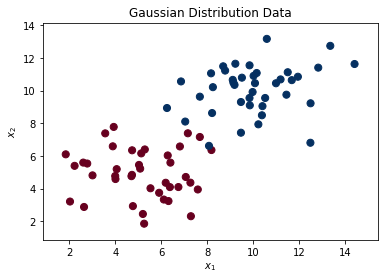

In [18]:
fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='RdBu')

xlim = (min(X_train[:, 0]) - 1, max(X_train[:, 0]) + 1)
ylim = (min(X_train[:, 1]) - 1, max(X_train[:, 1]) + 1)

plt.grid(False)
ax.set(xlim = xlim, ylim = ylim)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Gaussian Distribution Data")
plt.show()

**STEP 4:** Let's test the inference procedure on the test data.
- Let's get the class predictions for the test examples.

In [19]:
y_test_pred = gaussian_nb.predict(X_test)
print(y_test_pred)

[0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1]


Now, we generate a classification report containing information about different classification evaluation metrics like precision, recall, F1-score and accuracy.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



This seems like a perfect classifier.

Let's obtain the probability of each example belonging to each class.

In [21]:
gaussian_nb.predict_prob(X_test)

array([[9.99995472e-01, 4.52839932e-06],
       [9.99996766e-01, 3.23390275e-06],
       [7.16520989e-05, 9.99928348e-01],
       [6.66870407e-03, 9.93331296e-01],
       [9.99601942e-01, 3.98057726e-04],
       [2.85255603e-06, 9.99997147e-01],
       [9.50012762e-01, 4.99872380e-02],
       [9.99999999e-01, 5.14995390e-10],
       [2.38934300e-05, 9.99976107e-01],
       [2.35847135e-06, 9.99997642e-01],
       [1.07401727e-04, 9.99892598e-01],
       [9.12388164e-01, 8.76118356e-02],
       [9.99999580e-01, 4.19641315e-07],
       [9.99999992e-01, 8.40624938e-09],
       [4.04225507e-05, 9.99959577e-01],
       [1.01014295e-02, 9.89898570e-01],
       [4.46888808e-03, 9.95531112e-01],
       [9.99999343e-01, 6.57434234e-07],
       [9.99999889e-01, 1.11467083e-07],
       [1.28887335e-03, 9.98711127e-01]])

Let's make a prediction for a new data point, and try to match our intuition with the prediction.

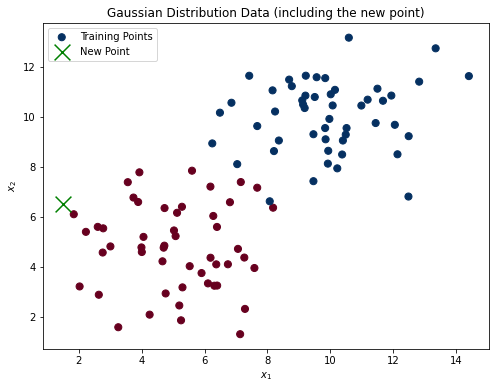

In [22]:
x_new = np.array([1.5, 6.5])

plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=50, cmap='RdBu', label="Training Points")
# plot the new point
plt.scatter(x_new[0], x_new[1], marker='x', c='green', s=250, label="New Point")

plt.grid(False)

plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Gaussian Distribution Data (including the new point)")
plt.show()

Since, the data point is close to the Gaussian distribution wiht mean $[5,5]$, it should get the label of that class, i.e. it should be labelled as $0$.

In [23]:
gaussian_nb.predict(np.array([x_new]))

array([0])

In [24]:
gaussian_nb.predict_prob(np.array([x_new]))

array([[9.99992822e-01, 7.17793196e-06]])

Notice that the probability of the new example belonging to class $0$, which has a mean of $[5,5]$ is $0.99$, which is much larger than the other class and hence it is assigned the class label of $0$.

### Multiclass Classification

Our implementation also works for the multi-class case. Here is a demo:
- We generate $120$ examples from three classes with means $[5,5], [10,10]$ and $[15,15]$.
- Each example has $2$ features.

In [25]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# generate synthetic data with 3 classes.
# each example has 2 features.
X,y = make_blobs(
    n_samples = [40, 40, 40],
    n_features= 2,
    centers= [[5,5], [10,10], [15,15]],
    cluster_std = 1.5,
    random_state = 69,
)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/6, random_state=69)

Let's visualize this:

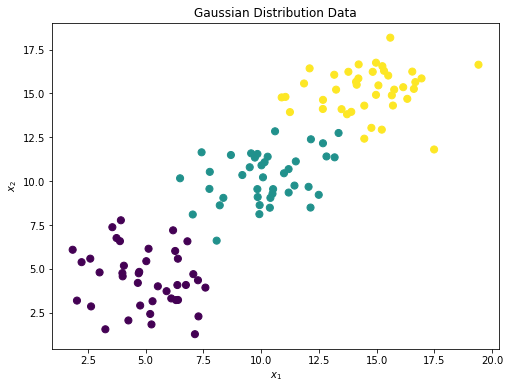

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=50)
plt.grid(False)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Gaussian Distribution Data")
plt.show()

Let's estimate the parameters of the Gaussian distributions.

In [27]:
gaussian_nb_multiclass = GaussianNB()
gaussian_nb_multiclass.fit(X_train, y_train)

Mean:
 [[ 4.84047128  4.6377248 ]
 [10.18015209  9.96561358]
 [14.51739548 15.24365634]]
Variance:
 [[2.51342009 2.82258373]
 [2.83803076 1.86269776]
 [3.17482332 1.46416694]]
Priors:
 [0.32 0.33 0.35]


As we can see, the estimated means of each class is close to the actual means.

Let's use the estimated parameters to make prediction on test examples and generate a classification evaluation report.

In [28]:
from sklearn.metrics import classification_report
y_test_pred = gaussian_nb_multiclass.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Again, we obtain a perfect classifier.

Finally, we can also predict the probability of each test example belonging to the three different classes.

In [29]:
gaussian_nb_multiclass.predict_prob(X_test)

array([[1.69886772e-15, 2.52832565e-05, 9.99974717e-01],
       [9.99999992e-01, 8.30058162e-09, 7.34579497e-32],
       [9.98922367e-01, 1.07763277e-03, 1.22534553e-18],
       [9.99998799e-01, 1.20091775e-06, 4.31005408e-26],
       [1.85218427e-06, 9.99986415e-01, 1.17323429e-05],
       [9.99999291e-01, 7.08887668e-07, 6.26772528e-25],
       [5.93678957e-19, 8.41221966e-06, 9.99991588e-01],
       [4.27857031e-06, 9.99697059e-01, 2.98662226e-04],
       [2.98858977e-04, 9.99660394e-01, 4.07470382e-05],
       [6.24880952e-08, 8.79857884e-01, 1.20142054e-01],
       [9.99999782e-01, 2.17947565e-07, 1.68639335e-25],
       [9.99806550e-01, 1.93449899e-04, 3.17469704e-21],
       [9.99999981e-01, 1.92687808e-08, 2.27274742e-29],
       [2.75648140e-16, 6.47929879e-03, 9.93520701e-01],
       [2.14250837e-09, 9.60209460e-01, 3.97905378e-02],
       [1.21705449e-06, 9.99241908e-01, 7.56874722e-04],
       [4.92298819e-18, 4.27455805e-05, 9.99957254e-01],
       [6.81873844e-19, 4.16511

# Multinomial NB: Implementation

We use **multinomial NB** for problems like **document classification**.
- We represent the $i$-th document with a vector $\vec{x}^{(i)}$ containing counts of words in the vocabulary $\{x^{(i)}_1, x^{(i)}_2, \dots, x^{(i)}_m \}$.
- The sum of all feature count is equal to the total no. of words in the document, i.e. $\sum^{m}_{j = 1} x^{(i)}_j = l$.

Mathematically we can represent this as:
$$\vec{x}|y_r \sim \text{Multinomial} (w_{1 y_r}, w_{2 y_r}, \dots, w_{m y_r}) = \text{Multinomial} (\vec{w}_{y_r}) $$
$$p(\vec{x}|y_r; l, \vec{w_{y_r}}) = \frac{n !}{x_1 ! x_2 ! \dots x_m !} \prod^{m}_{j = 1} w^{x_j}_{j y_r} $$

The **total number of parameters** = $m \times k + k$, where
- $m \times k$ is the total no. of features for $k$ multinomial distributions and
- $k$ is total no. of priors.

## Parameter Estimation

The $j$-th component of parameter vector $w_{y_r}$ for multinomial distribution of class $y_r$ is calculated as follows:
$$w_{j y_r} = \frac{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)} x^{(i)}_j}{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)} \sum^{m}_{j=1} x^{(i)}_j} $$

Here,
- The numerator is the **sum of features** $x_j$ for $all examples$ from class $y_r$.
- The denominator is the total count of features from all exampled from class $y_r$.

With **Laplace Correction:**
$$w_{j y_r} = \frac{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)} x^{(i)}_j + \alpha}{\sum^{n}_{i = 1} \mathbb{1}_{(y^{(i)} = y_r)} \sum^{m}_{j=1} x^{(i)}_j + m \alpha} $$

> For laplace correction $\alpha = 1$.

## Inference

In log space the calculation is performed as follows:
- In the numerator, we first multiply the count matrix with transpose of log of weight vector and add it to the log prior probabilities. And exponentiate the resulting value.
- In the denominator, we perform the same calculation as numerator but for different class labels and sum them up.
- The denominator normalizes the numerator between $0$ and $1$, thus giving the posterior probability of label $y_c$ for the given count vector $\vec{x}$.
$$p(y_c|\vec{x}; l, \vec{w}_{y_c}) = \frac{\exp (\vec{x}(\log \vec{w}_{y_c})^T) + \log p(y_c)}{\sum_{r} \exp (\vec{x}(\log \vec{w}_{y_r})^T) + \log p(y_r)}$$
> Note, that while giving the output as labels, it is sufficient to calculate the numerator in the log-space.

## Implementation of Multinomial NB Class

In [30]:
class MultinomialNB(object):
    '''
    Class Conditional Density following Multinomial Distribution
    '''

    def fit(self, X, y, alpha=1):
        '''
        Parameter estimation for Multinomial NB
        '''
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate the parameters of 'k' multinomial distribution and priors.
        # initialize the weight vectors
        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_prior = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes): # processing examples from each class separately
            # extract examples with label c
            X_c = X[y==c]

            # get the total count of features for class c
            total_count = np.sum(np.sum(X_c, axis=1))

            # estimate parameters of multinomial distribution for class c
            self.w[idx, :] = (np.sum(X_c, axis=0) + alpha) / float(total_count + n_features * alpha)

            # estimate class prior for class c
            self.w_prior[idx] = (X_c.shape[0] + alpha) / float(n_samples + n_classes * alpha)
        
        print("CCD Weights:\n", self.w)
        print("Priors:\n", self.w_prior)

    def log_likelihood_prior_prod(self, X):
        '''
        Calculates the product of likelihood and prior in the log space
        '''
        return X @ (np.log(self.w).T) + np.log(self.w_prior)

    def predict_prob(self, X):
        '''
        Calculates probabilities of each example belonging to different classes.
        '''
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q)/(np.expand_dims(np.sum(np.exp(q), axis=1), axis=1))

    def predict(self,X):
        '''
        Predicts class label for each example.
        '''
        return np.argmax(self.log_likelihood_prior_prod(X), axis=1)

## Demo

Our implementation works for both binary and multiclass settings.

### Binary Classification

Generate synthetic data with $1000$ examples for $2$ classes where each example has $5$ features.

In [31]:
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1)
X = rng.randint(5, size=(1000, 5))
y = rng.randint(2, size=(1000,))

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=69)

In [32]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(750, 5) (250, 5)
(750,) (250,)


Estimate the parameters of multinomial NB.

In [33]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

CCD Weights:
 [[0.21396523 0.19209198 0.18844644 0.1977005  0.20779585]
 [0.2104867  0.19643753 0.19944807 0.19894631 0.19468138]]
Priors:
 [0.47606383 0.52393617]


Observe:
- Each class is almost equally likely - each has probability of approximately $0.5$.
- Sum of probabilies of different features of each class = 1.

Let's evaluate the classifier.

In [34]:
from sklearn.metrics import classification_report

y_test_pred = multinomial_nb.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35       128
           1       0.51      0.80      0.62       122

    accuracy                           0.52       250
   macro avg       0.54      0.53      0.48       250
weighted avg       0.54      0.52      0.48       250



Notice that the accuracy isn't that good. This is due to high no. of features adn random label assignment in the synthetic data.

Let's calculate the probability of each example belinging to both the one of the classes.

In [35]:
multinomial_nb.predict_prob(X_test[:10])

array([[0.48818726, 0.51181274],
       [0.4513767 , 0.5486233 ],
       [0.4827531 , 0.5172469 ],
       [0.46438299, 0.53561701],
       [0.47110797, 0.52889203],
       [0.49352192, 0.50647808],
       [0.45056857, 0.54943143],
       [0.48286826, 0.51713174],
       [0.42986851, 0.57013149],
       [0.48600607, 0.51399393]])

As we can see, unlike the previous cases, the probabilities are pretty close to each other (random assignment).

## Multiclass Classification

Generate synthetic data with $1200$ examples for $3$ classes where each example has $5$ features.

In [36]:
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1)
X = rng.randint(5, size=(1200, 5))
y = rng.randint(3, size=(1200,))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/6 ,random_state=69)

Let's estimate the parameters of multinomial naive Bayes classifier.

In [37]:
multinomial_nb_multiclass = MultinomialNB()
multinomial_nb_multiclass.fit(X_train, y_train)

CCD Weights:
 [[0.20630462 0.19818976 0.20318352 0.1963171  0.19600499]
 [0.21786198 0.19512855 0.19269283 0.19810555 0.1962111 ]
 [0.20854271 0.18938442 0.19189698 0.20383166 0.20634422]]
Priors:
 [0.31704885 0.36590229 0.31704885]


Let's evaluate the learnt classifier.

In [38]:
from sklearn.metrics import classification_report

y_test_pred = multinomial_nb_multiclass.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.16      0.06      0.08        54
           1       0.40      0.84      0.54        76
           2       0.55      0.16      0.24        70

    accuracy                           0.39       200
   macro avg       0.37      0.35      0.29       200
weighted avg       0.39      0.39      0.31       200



The accuracy is even worse. We will get a similar accuracy with just a Baseline constant model (choosing any of the $3$ class for every example). So, the model isn't really learning anything significant. This is because of the random label assignment in the synthetic data.

Finally we can predict the probability for test examples of belonging to different classes.

In [40]:
multinomial_nb_multiclass.predict_prob(X_test[:10])

array([[0.34865959, 0.32314016, 0.32820026],
       [0.31130459, 0.38882602, 0.29986938],
       [0.32289302, 0.37243743, 0.30466954],
       [0.2865287 , 0.37783087, 0.33564043],
       [0.29152612, 0.40706016, 0.30141372],
       [0.34526944, 0.38705191, 0.26767865],
       [0.29833396, 0.37882538, 0.32284065],
       [0.31917719, 0.35781855, 0.32300427],
       [0.30472251, 0.36469221, 0.33058528],
       [0.31350061, 0.37905949, 0.3074399 ]])

As we can see, the model isn't really sure which label to assign as each class is almost equally likely.

So, no meaningful learning is happening in this particular case.

# Summary

- We implement **Naive Bayes' Classifiers** from scratch.
- We implement these model:
    - **Bernoulli Naive Bayes' Model**
    - **Gaussian Naive Bayes' Model**
    - **Multinomial Naive Bayes' Model**
- We analyze the model, estimation of weights and inference in all three of them.
- We train the model in binary and multi-class set ups for all three of them and check the performance for each.

For mathematical derivation visit this [link](https://github.com/sampadk04/Naive_Bayes_Classifier_from_scratch/blob/main/Naive_Bayes_Classifier_Notes.pdf).